<a href="https://colab.research.google.com/github/germanjke/Global_Wheat_Detection/blob/master/yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm
import shutil as sh
import torch
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
def set_seed(seed=42):
    """Sets the random seeds."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
 
set_seed()

In [4]:
!git clone https://github.com/ultralytics/yolov5 "/content/drive/My Drive/GWD/yolov5"

fatal: destination path '/content/drive/My Drive/GWD/yolov5' already exists and is not an empty directory.


In [5]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Cloning into 'apex'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7358 (delta 0), reused 0 (delta 0), pack-reused 7353
Receiving objects: 100% (7358/7358), 13.88 MiB | 29.49 MiB/s, done.
Resolving deltas: 100% (4971/4971), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-xw6qqrss
Created temporary directory: /tmp/pip-req-tracker-4eyxq26g
Created requirements tracker '/tmp/pip-req-tracker-4eyxq26g'
Created temporary directory: /tmp/pip-install-xi2e49bt
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-7qez_g6g
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-4eyxq26g'
    Running setup.py (path:

In [6]:
!cd "/content/drive/My Drive/GWD/yolov5"
!mv yolov5/* ./

mv: cannot stat 'yolov5/*': No such file or directory


In [7]:
!ls | cat
!pip install -r "/content/drive/My Drive/GWD/yolov5/requirements.txt"

drive
sample_data
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ayv4d9gb
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ayv4d9gb
     |████████████████████████████████| 20.4MB 38.1MB/s 
     |████████████████████████████████| 276kB 39.0MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=29af006d4ae324ceb07630d2c79a7dd83459fca911084ec9d048733aa0959166
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266459 sha256=e9e85f8df473cef0b261c61160725e117945a7406f22ba32f5702f37a710cece
  Stored in directory: /tmp/pip-ephem-wheel-cache-sivu3esf/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built PyYAML pycocotools
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0

In [8]:
'''
! pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import drive
#drive.mount('/content/gdrive')
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c global-wheat-detection
!unzip /content/global-wheat-detection.zip -d '/content/drive/My Drive/GWD/global-wheat-detection' > /dev/null
'''

'\n! pip install --upgrade --force-reinstall --no-deps kaggle\nfrom google.colab import drive\n#drive.mount(\'/content/gdrive\')\n!mkdir -p ~/.kaggle\n!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n!kaggle competitions download -c global-wheat-detection\n!unzip /content/global-wheat-detection.zip -d \'/content/drive/My Drive/GWD/global-wheat-detection\' > /dev/null\n'

In [9]:
df = pd.read_csv('/content/drive/My Drive/GWD/global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0

df = df[['image_id','x', 'y', 'w', 'h', 'x_center', 'y_center', 'classes']]

In [10]:
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0


In [11]:
df.iloc[0]['image_id']

'b6ab77fd7'

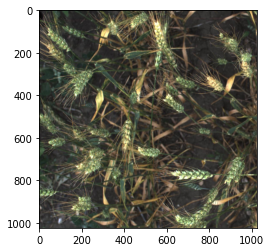

In [12]:
import cv2
import torch
import matplotlib.pyplot as plt

img_id = 'b6ab77fd7'

img = cv2.imread(os.path.join('/content/drive/My Drive/GWD/global-wheat-detection/train', img_id + '.jpg'), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img /= 255.0

records = df[df['image_id'] == img_id]
boxes = records[['x', 'y', 'w', 'h']].values

boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # x2 = x1 + w
boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # y2 = y1 + h

labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
target = {}
target['boxes'] = boxes
target['labels'] = labels
target['image_id'] = torch.tensor(0)

img = torch.tensor(img)
#print(torch.tensor(img).permute(1, 2, 0).shape)
plt.imshow(img)

(1024, 1024, 3)


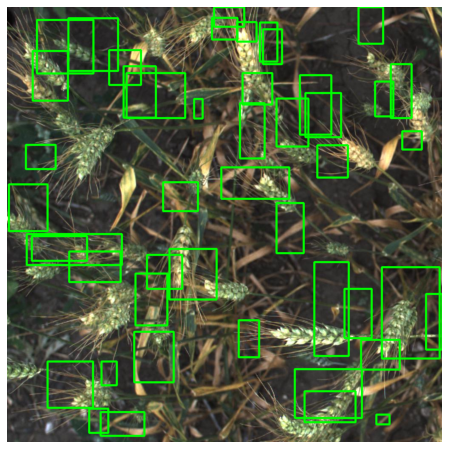

In [13]:
boxes = target['boxes'].astype(np.int32)
np_img = img.cpu().numpy()
#np_img = img.permute(1, 2, 0).cpu().numpy()
print(np_img.shape)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
  cv2.rectangle(np_img, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 3) # start, end points / try to fix

ax.set_axis_off()
ax.imshow(np_img)

In [14]:
index = list(set(df.image_id))

In [15]:
#подсчёт площади каждого бокса
w_list = df.w.to_list()
h_list = df.h.to_list()
area_list = [w*h for w,h in zip(w_list,h_list)]

df['area'] = area_list


#delete big areas
big_boxes_indexes = df[df.area >= 75000].index.tolist() #обозначим список больших боксов по индексу
df.drop(df.index[big_boxes_indexes], inplace = True)

In [16]:
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/content/drive/My Drive/GWD/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/content/drive/My Drive/GWD/fold{}/labels/'.format(fold)+path2save)
            with open('/content/drive/My Drive/GWD/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/content/drive/My Drive/GWD/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/content/drive/My Drive/GWD/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/My Drive/GWD/global-wheat-detection/{}/{}.jpg".format(source,name),'/content/drive/My Drive/GWD/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

In [17]:
!nvidia-smi

Sat Jul 18 11:07:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python "/content/drive/My Drive/GWD/yolov5/train.py" --img 1024 --batch 2 --epochs 100 --data "/content/drive/My Drive/GWD/wheat0.yaml" --cfg "/content/drive/My Drive/GWD/yolov5x.yaml" --name yolov5x_fold0 --weights "/content/drive/My Drive/GWD/yolov5x.pt"

{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=2, bucket='', cache_images=False, cfg='/content/drive/My Drive/GWD/yolov5x.yaml', data='/content/drive/My Drive/GWD/wheat0.yaml', device='', epochs=100, evolve=False, img_size=[1024], multi_scale=False, name='yolov5x_fold0', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='/content/drive/My Drive/GWD/yolov5x.pt')
Using CUDA Apex device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

2020-07-18 11:07:52.185026: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensorboard --logdir=runs", view at http://localho